
# SVR with Optimized Grid Search (Lightweight)

This notebook trains a Support Vector Regressor (SVR) with preprocessing and a reduced Grid SearchCV for faster runtime.  
Modify `target_col` if your dataset's target is different.

**Artifacts saved during execution:**
- `/mnt/data/best_svr_model.joblib`
- `/mnt/data/svr_grid_results.csv`
- `/mnt/data/svr_metrics_summary.json`


In [1]:

import os, json, math
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from joblib import dump


In [2]:

# Load dataset
csv_path = "/content/train.csv"  # adjust if needed
df = pd.read_csv(csv_path)

# Auto-select target column (last column if unknown)
COMMON_TARGETS = ["target","Target","TARGET","label","Label","LABEL","y","Y","price","Price","SalePrice","score","Score"]
target_col = None
for cand in COMMON_TARGETS:
    if cand in df.columns:
        target_col = cand
        break
if target_col is None:
    target_col = df.columns[-1]

df[target_col] = pd.to_numeric(df[target_col], errors="coerce")
df = df.dropna(subset=[target_col]).reset_index(drop=True)

X = df.drop(columns=[target_col])
y = df[target_col].astype(float)

numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

print("Target column:", target_col)
print("Numeric cols:", numeric_cols)
print("Categorical cols:", categorical_cols)


Target column: Loan Sanction Amount (USD)
Numeric cols: ['Age', 'Income (USD)', 'Loan Amount Request (USD)', 'Current Loan Expenses (USD)', 'Dependents', 'Credit Score', 'No. of Defaults', 'Property ID', 'Property Age', 'Property Type', 'Co-Applicant', 'Property Price']
Categorical cols: ['Customer ID', 'Name', 'Gender', 'Income Stability', 'Profession', 'Type of Employment', 'Location', 'Expense Type 1', 'Expense Type 2', 'Has Active Credit Card', 'Property Location']


In [3]:

from sklearn.impute import SimpleImputer

# Preprocessing for numeric and categorical data
numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numeric_cols),
    ("cat", categorical_transformer, categorical_cols),
], remainder="drop")

pipe = Pipeline([("prep", preprocessor), ("svr", SVR())])


In [4]:

# Reduced grid for faster search
param_grid = [
    {"svr__kernel": ["rbf"], "svr__C": [1.0, 10.0, 100.0], "svr__epsilon": [0.1, 0.2, 0.5], "svr__gamma": ["scale", "auto"]},
    {"svr__kernel": ["linear"], "svr__C": [0.1, 1.0, 10.0], "svr__epsilon": [0.1, 0.2, 0.5]},
]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
cv = KFold(n_splits=3, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="neg_mean_squared_error",
    refit=True,
    cv=cv,
    n_jobs=-1,
    verbose=0
)

grid.fit(X_train, y_train)
print("Best Params:", grid.best_params_)


Best Params: {'svr__C': 10.0, 'svr__epsilon': 0.5, 'svr__kernel': 'linear'}


In [5]:

# Evaluate on the held-out test set
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = math.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Test MSE:", mse)
print("Test RMSE:", rmse)
print("Test MAE:", mae)
print("Test R^2:", r2)


Test MSE: 1267842844.6493883
Test RMSE: 35606.780880183316
Test MAE: 18329.29791550522
Test R^2: 0.44142344812867673


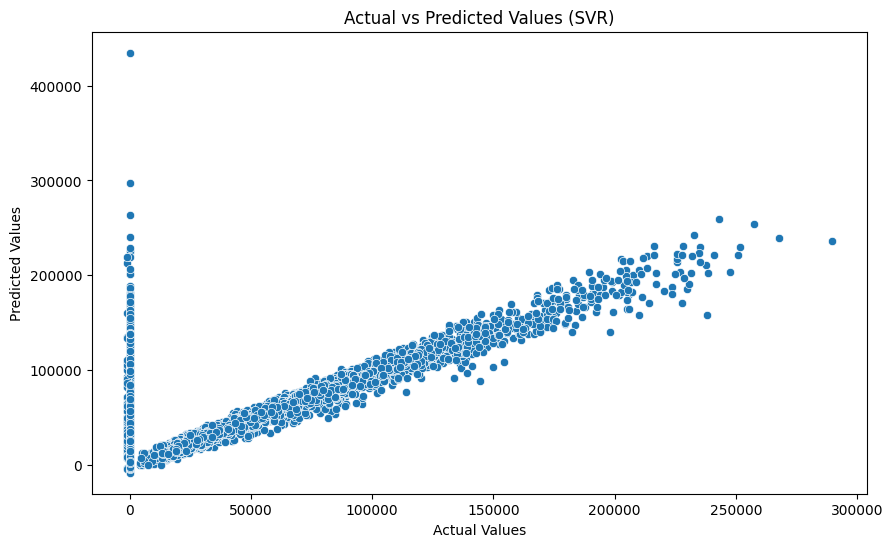

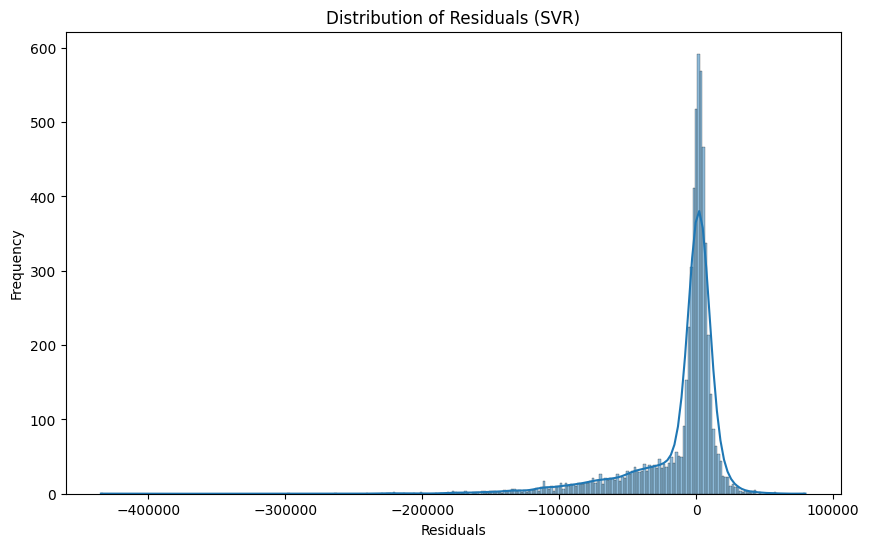

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot of actual vs predicted values
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values (SVR)")
plt.show()

# Histogram of residuals
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals (SVR)")
plt.show()